# Stock trading optimization



In [24]:
# This code cell installs packages on Colab

import sys
if "google.colab" in sys.modules:
    !wget "https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/helper.py"
    import helper
    helper.install_idaes()
    helper.install_ipopt()
    helper.install_glpk()

--2024-01-05 16:08:10--  https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6463 (6.3K) [text/plain]
Saving to: ‘helper.py.4’

helper.py.4         100%[===================>]   6.31K  --.-KB/s    in 0.001s  

2024-01-05 16:08:10 (6.68 MB/s) - ‘helper.py.4’ saved [6463/6463]

IDAES found! No need to install.
Ipopt found! No need to install.
ipopt was successfully installed
k_aug was successfully installed
Installing glpk via apt-get...


In [25]:
## IMPORT LIBRARIES
import pyomo.environ as pyo
import pandas as pd
!apt-get install -y -qq coinor-cbc
!apt-get update
!apt-get install -y glpk-utils

# !apt-get install -y -qq coinor-cbc
# !apt-get install -y -qq glpk-utils
# !apt-get install -y -qq ipopt


Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
glpk-utils is already the newest version (5.0-1).
0 upgraded, 0 newly installed, 0 to remove and 27 not upgraded.


### Trade optimization

Aim to optimize trading signals based on real data that maximize the total capital at the end of the time period. The aim is to then use these signals as the target variable neural network trained on the same data, where the neural network can best learn the 'rules' based on data or features cleaned from data, that gives the signals that maximize capital. 

*   \( $t$ \): Index representing time points.

Decision Variables

*   \( $q_{t}$ \): Quantity of stock held at time \( $t$ \).
*   \( $b_{t}$ \): Quantity of stock bought at time \( $t$ \).
*   \( $s_{t}$ \): Quantity of stock sold at time \( $t$ \).
*   \( $c_t$ \): Cash available at time \( $t$ \).

Parameters
*   \( $n_{t}$ \): Number of time points in the stock data.   
*   \( $c_0$ \): Initial cash value.











In [30]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Navigate to the directory
%cd '/content/drive/MyDrive/Colab Notebooks/data/_stock_history/'

# Upload the file
from google.colab import files
# uploaded = files.upload()
#
# Load the data using Pyomo
import pandas as pd
from pyomo.environ import *

# Assuming the uploaded file is named 'SPY.csv'
data = pd.read_csv('SPY.csv')
# print(data)


# Change back to current dirctory
%cd '/content'

%pwd
# %cd '/content/drive/MyDrive/Colab Notebooks/Optimization/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/data/_stock_history
/content


'/content'

In [49]:
import pandas as pd
from pyomo.environ import *
import numpy as np

### For randomized data use these
# # Sample DataFrame
# # You need to replace this with your actual stock data
# data = {
#     'Date': ['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04'],
#     'Close': [100, 105, 98, 110]
# }

# Generate sample data for 30 days
# np.random.seed(42)  # for reproducibility
# n_days = 30
# closing_prices = np.random.randint(80, 120, size=n_days)

# # Create a DataFrame
# data = {
#     'Date': pd.date_range(start='2023-01-01', periods=n_days).strftime('%Y-%m-%d'),
#     'Close': closing_prices
# }

stock_data = pd.DataFrame(data)
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

initial_cash_value = 10000

# Pyomo model
model = ConcreteModel()

# Decision variables
model.quantity_holding = Var(stock_data.index, within=NonNegativeIntegers, initialize=0)  # variable for quantity holding
model.quantity_bought = Var(stock_data.index, within=NonNegativeIntegers, initialize=0)  # variable for quantity buying
model.quantity_sold = Var(stock_data.index, within=NonNegativeIntegers, initialize=0)  # variable for quantity selling
model.cash = Var(stock_data.index, within=NonNegativeReals, initialize=0)  # variable for cash available at each time
# model.cash = Var(stock_data.index, within=NonNegativeReals, bounds=(0, max_cash_limit))

# Constraints
def quantity_balance_rule(model, t):
    if t == stock_data.index[0]:
        # Initial condition for quantity balance
        return model.quantity_holding[t] == model.quantity_bought[t] - model.quantity_sold[t]
    else:
        # Quantity balance constraint for subsequent time periods
        return model.quantity_holding[t] == model.quantity_holding[t-1] + model.quantity_bought[t] - model.quantity_sold[t]

model.quantity_balance_constraint = Constraint(stock_data.index, rule=quantity_balance_rule)

def cash_balance_rule(model, t):
    if t == stock_data.index[0]:
        # Initial condition for cash balance
        return model.cash[t] == initial_cash_value - stock_data['Close'][t]*model.quantity_bought[t] + stock_data['Close'][t]*model.quantity_sold[t]
    else:
        # Cash balance constraint for subsequent time periods
        return model.cash[t] == model.cash[t-1] - stock_data['Close'][t-1]*model.quantity_bought[t] + stock_data['Close'][t-1]*model.quantity_sold[t]

model.cash_balance_constraint = Constraint(stock_data.index, rule=cash_balance_rule)

def initial_cash_rule(model):
    # Initial cash constraint
    return model.cash[stock_data.index[0]] == initial_cash_value

model.initial_cash_constraint = Constraint(rule=initial_cash_rule)

# Objective function
def objective_rule(model):
    # Objective: Maximize the final capital value
    return model.cash[stock_data.index[-1]] + stock_data['Close'][stock_data.index[-1]] * model.quantity_holding[stock_data.index[-1]]

model.objective = Objective(rule=objective_rule, sense=maximize)

# # Solve the optimization problem
ipopt_executable = '/root/.idaes/bin/ipopt'
solver = SolverFactory('ipopt', executable=ipopt_executable, tee=True)  # you can use other solvers like 'cbc', 'gurobi', etc.
solver.solve(model)

# Display the results
prnt_out = False
if prnt_out:
    for t in stock_data.index:
        print(f"Date: {stock_data['Date'][t]}, "
              f"Quantity Holding: {model.quantity_holding[t].value}, "
              f"Quantity Bought: {model.quantity_bought[t].value}, "
              f"Quantity Sold: {model.quantity_sold[t].value}, "
              f"Cash: {model.cash[t].value}")

# # Display the final portfolio value
# final_portfolio_value = sum(stock_data['Closing_Price'][t] * model.quantity_holding[t].value for t in stock_data.index)
# print(f"Final Portfolio Value: {final_portfolio_value}")




  - termination condition: maxIterations
  - message from solver: Ipopt 3.13.2\x3a Maximum Number of Iterations Exceeded.


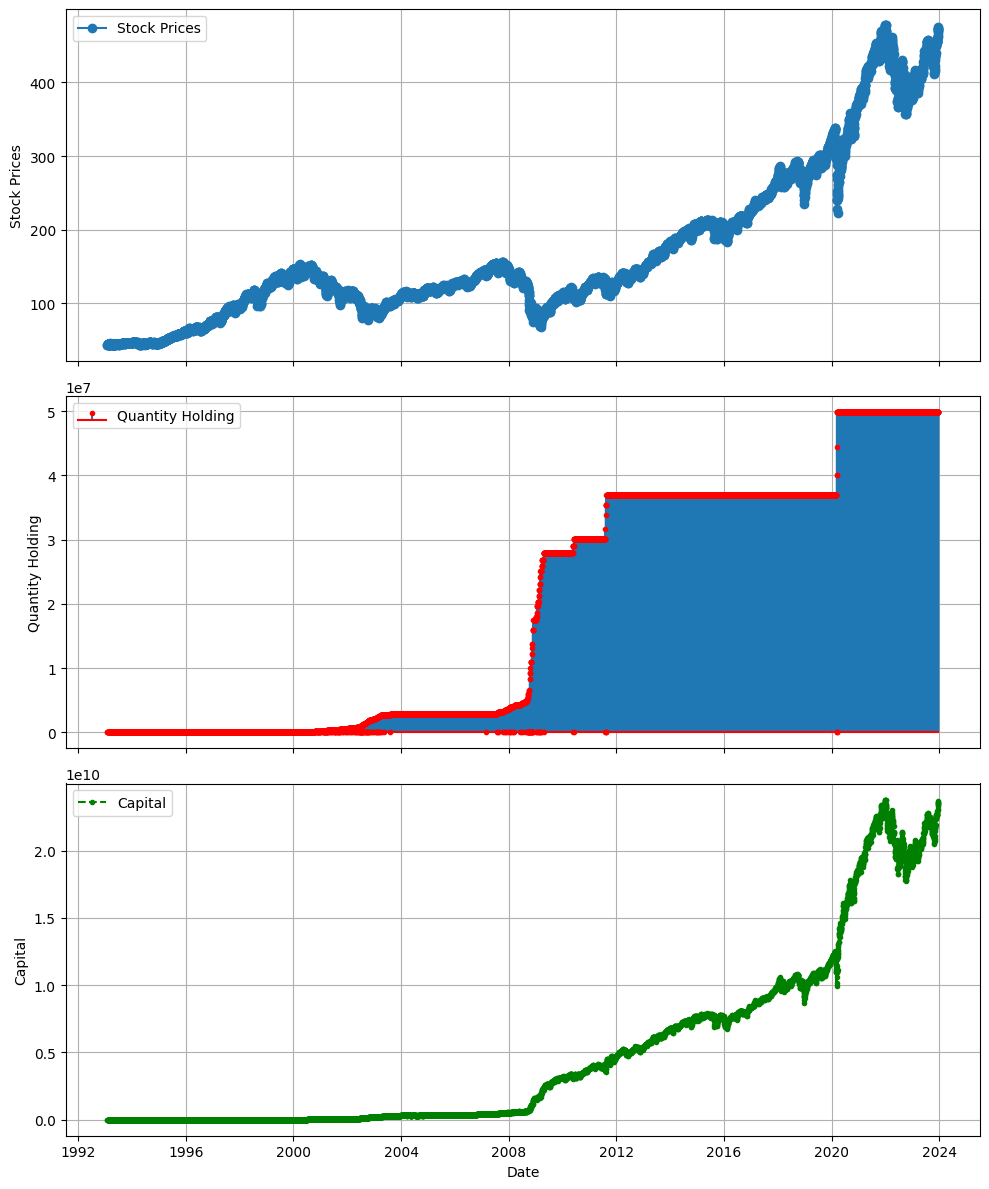

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Extract model results
quantity_holding_values = [model.quantity_holding[t].value for t in stock_data.index]
cash_values = [model.cash[t].value for t in stock_data.index]

# Calculate capital at each time step based on Pyomo model results
capital_values = [initial_cash_value + stock_data['Close'][0] * model.quantity_holding[0].value]

n_days = stock_data.Date.shape[0]
for t in range(1, n_days):
    cash_values_t = model.cash[t-1].value
    cash_values.append(cash_values_t)

    # Adjust cash for transactions on day t
    cash_values_t -= stock_data['Close'][t] * model.quantity_bought[t].value
    cash_values_t += stock_data['Close'][t] * model.quantity_sold[t].value

    # Calculate capital at the end of day t
    capital_t = cash_values_t + stock_data['Close'][t] * model.quantity_holding[t].value
    capital_values.append(capital_t)


# Plotting in subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Plot stock prices
axs[0].plot(stock_data['Date'], stock_data['Close'], label='Stock Prices', marker='.')
axs[0].set_ylabel('Stock Prices')
axs[0].grid(True)
axs[0].legend()

# Plot quantity of stock you own
axs[1].stem(stock_data['Date'], quantity_holding_values, label='Quantity Holding', markerfmt='r.', basefmt='r-')#, linefmt='r--', basefmt='r-')
axs[1].set_ylabel('Quantity Holding')
axs[1].grid(True)
axs[1].legend()

# Plot capital
axs[2].plot(stock_data['Date'], capital_values, label='Capital', marker='.', linestyle='dashed', color='green')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Capital')
axs[2].grid(True)
axs[2].legend()

# Customize layout
plt.tight_layout()

# Show the plot
plt.show()
